In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.stats import norm
from scipy.optimize import curve_fit
import getdist.plots as gdplt
import getdist.mcsamples
from getdist import MCSamples, plots
import emcee
from tqdm import tqdm
c = 299792.458

In [206]:
fit_data = pd.read_csv('fuji_pv_full.csv')
fit_data

/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/1152719809.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  fit_data = pd.read_csv('fuji_pv_full.csv')


,#fibermap_targetid,fibermap_i,ra_1,dec_1,targetid,id,healpix,survey,program,targetid.1,...,pv_corr,pverr_corr,mu_a,mu_a_err,mu_a_cal,da_pred_all,res,da_pred_cal_all,res_cal,zmod
0,39628417112478213,400,192.260477,26.893112,39628417112478213,1301,28148,sv1,bright,39628417112478213,...,524.165632,1769.285380,1.830560,0.100876,1.976706,74.298477,-0.040420,101.778736,-0.030951,0.026067
1,39628417133447721,426,193.579225,27.068031,39628417133447721,1304,28149,sv1,bright,39628417133447721,...,3414.854109,1980.173823,1.736384,0.100492,1.882531,83.223683,-0.183863,114.005045,-0.174393,0.029380
2,39627769709071900,191,184.913600,-0.750861,39627769709071900,1516,26254,sv1,bright,39627769709071900,...,-2365.838643,2159.647080,2.053817,0.101379,2.199963,89.777557,0.100649,122.982954,0.110118,0.031838
3,39633076111803113,63,119.188267,39.927879,39633076111803113,996,6541,sv1,bright,39633076111803113,...,-77.188733,939.990915,1.583120,0.104726,1.729266,38.479059,-0.002105,52.711039,0.007365,0.013172
4,39628422523128777,203,193.922076,27.250763,39628422523128777,1304,28149,sv1,bright,39628422523128777,...,-1284.695449,1708.061104,1.920637,0.101095,2.066784,71.635457,0.065509,98.130764,0.074979,0.025086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4186,39632986789905375,570,252.485796,35.198279,39632986789905375,3347,9429,sv3,bright,39632986789905375,...,838.296840,12316.086652,2.400224,0.184584,2.546370,265.288081,-0.023494,363.408330,-0.014024,0.107005
4187,39627652587330772,44,36.125245,-5.566223,39627652587330772,933,17683,sv1,bright,39627652587330772,...,-1942.917085,3495.093250,2.155527,0.114780,2.301673,126.763229,0.052534,173.648259,0.062003,0.046143
4188,39627628545578443,30,36.097224,-6.412998,39627628545578443,922,17680,sv1,bright,39627628545578443,...,-5627.991997,4004.705590,2.302411,0.118116,2.448558,140.500921,0.154732,192.467015,0.164201,0.051648
4189,39633307725466372,337,173.525018,53.919783,39633307725466372,2657,5976,sv2,bright,39633307725466372,...,-12207.362099,9768.983616,2.536658,0.200605,2.682805,197.994045,0.240006,271.224719,0.249476,0.075899


(array([  5.,  16., 103., 166., 122., 101.,  81.,  99., 119., 219., 213.,
        236., 316., 253., 299., 415., 501., 364., 274., 289.]),
 array([0.00922149, 0.01376031, 0.01829914, 0.02283797, 0.02737679,
        0.03191562, 0.03645444, 0.04099327, 0.0455321 , 0.05007092,
        0.05460975, 0.05914857, 0.0636874 , 0.06822623, 0.07276505,
        0.07730388, 0.08184271, 0.08638153, 0.09092036, 0.09545918,
        0.09999801]),
 <BarContainer object of 20 artists>)

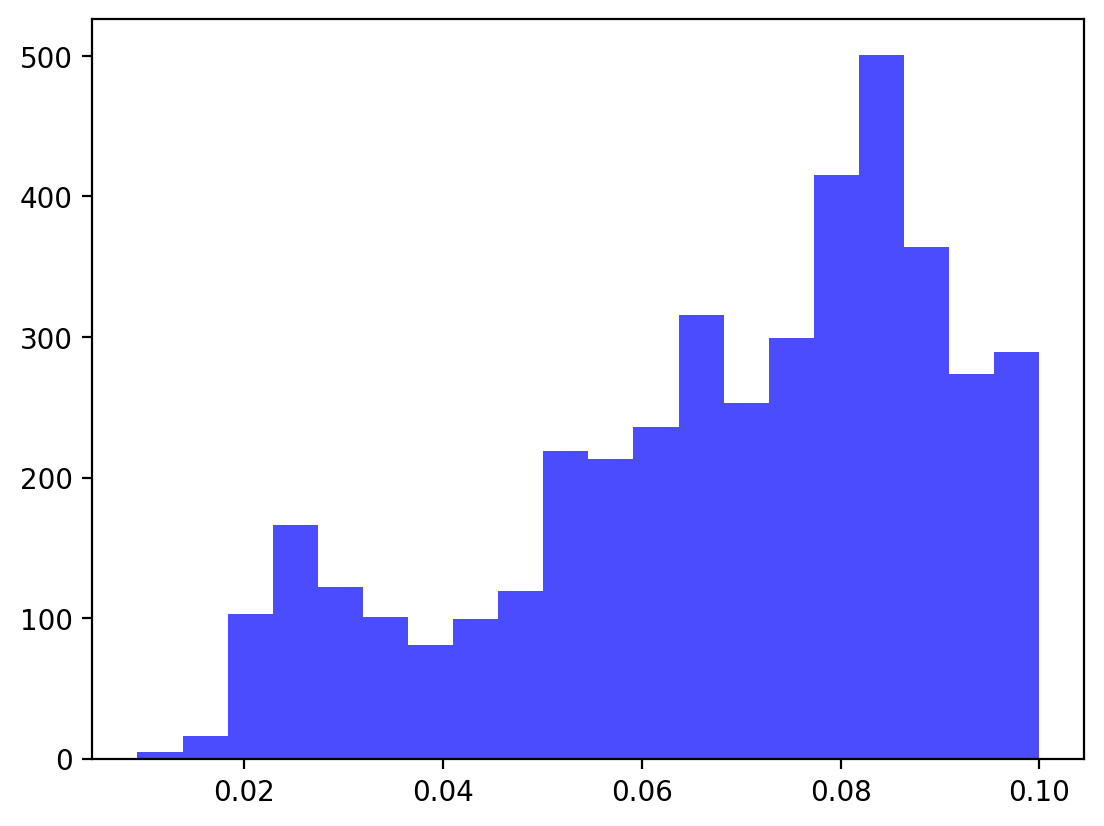

In [207]:
plt.hist(fit_data['zcmb'], bins=20, color='blue', alpha=0.7)

In [208]:
# Step 1: Add 0.75 * zcmb to mu_a_cal
fit_data['mu_a_cal'] += 1.22 * fit_data['zcmb']

# Step 2: Filter the DataFrame for rows where 0.016 < zcmb < 0.034
filtered_data = fit_data[(fit_data['zcmb'] > 0.016) & (fit_data['zcmb'] < 0.034)]

# Step 3: Calculate the mean correction added
mean_correction = (1.22 * filtered_data['zcmb']).mean()

# Step 4: Subtract the mean correction from mu_a_cal
fit_data['mu_a_cal'] -= mean_correction

# Step 5: Filter the DataFrame to include only rows where zcmb > 0.023
filtered_fit_data = fit_data[fit_data['zcmb'] > 0.023]

# Step 6: Create a new DataFrame with updated mu_a_cal, zcmb, and mu_a_err
fuji_pv_highz = filtered_fit_data#[['zcmb', 'mu_a_cal', 'mu_a_err']]

# Step 7: Save the new DataFrame to a CSV file (optional)
fuji_pv_highz.to_csv('corrected_fit_data.csv', index=False)

# Display the new DataFrame
print(fuji_pv_highz)

      #fibermap_targetid  fibermap_i        ra_1      dec_1  \
0      39628417112478213         400  192.260477  26.893112   
1      39628417133447721         426  193.579225  27.068031   
2      39627769709071900         191  184.913600  -0.750861   
4      39628422523128777         203  193.922076  27.250763   
6      39628430307758844         265  355.735958  27.470694   
...                  ...         ...         ...        ...   
4186   39632986789905375         570  252.485796  35.198279   
4187   39627652587330772          44   36.125245  -5.566223   
4188   39627628545578443          30   36.097224  -6.412998   
4189   39633307725466372         337  173.525018  53.919783   
4190   39627586577372913         174   35.756452  -8.314618   

               targetid    id  healpix survey program         targetid.1  ...  \
0     39628417112478213  1301    28148    sv1  bright  39628417112478213  ...   
1     39628417133447721  1304    28149    sv1  bright  39628417133447721  ...   


In [209]:
def k_modulus(z, H0, q0, j0):
    return np.log10(c * z * ((1.) + ((1./2.)*(1. - q0) * z) - ((1./6.) * (1. - q0 - 3. * q0**2 + j0) * z**2) ) ) - np.log10(H0) - 2. * np.log10(1 + z)

In [211]:
fixed_q0 = -0.535
fixed_j0 = 1.

x0 = fuji_pv_highz.zcmb 
y0 = fuji_pv_highz.mu_a_cal 
err0 = fuji_pv_highz.mu_a_err


def modified_k_modulus(z, H0):
    return k_modulus(z, H0, fixed_q0, fixed_j0)

initial_guess = [50.]

params_mod, cov_mod = curve_fit(modified_k_modulus, x0, y0, p0=initial_guess, sigma=err0)

H0_fit_mod = params_mod
H0_uncertainty_mod = cov_mod

print(np.round(H0_fit_mod[0],2),"+/-",np.round(H0_uncertainty_mod[0][0],2))

n = len(x0)
residuals = y0 - modified_k_modulus(x0, H0_fit_mod)
chi2_value = np.sum((residuals / err0) ** 2)
dof = n - 1 
alpha = 0.05

uncertainty = np.sqrt(np.sum(residuals**2) / dof)

reduced_chi2 = chi2_value / dof

print(f'Fitted Hubble Constant (H0): {np.round(H0_fit_mod,2)} km/s/Mpc')
print(f'Uncertainty (standard error): {uncertainty:.2f}')
print(f'Reduced Chi-squared: {reduced_chi2:.2f}')

67.41 +/- 0.08
Fitted Hubble Constant (H0): [67.41] km/s/Mpc
Uncertainty (standard error): 0.12
Reduced Chi-squared: 1.05


In [212]:
def log_likelihood(params, x, y, yerr):
    H0 = params
    model = k_modulus(x, H0, fixed_q0, fixed_j0)
    chi_squared = ((y - model) / yerr) ** 2
    return -0.5 * np.sum(chi_squared)

def log_prior(params):
    H0 = params
    if 50 <= H0 <= 100:
        return 0.0
    return -np.inf

def log_posterior(params, x, y, yerr):
    log_prior_result = log_prior(params)
    if not np.isfinite(log_prior_result):
        return -np.inf
    return log_prior_result + log_likelihood(params, x, y, yerr)

nwalkers = 100
nsteps = 1000

fixed_q0 = -0.55
fixed_j0 = 1.0

initial_parameters = np.array([70.])  # H0

p0 = [initial_parameters + 1e-3 * np.random.randn(1) for _ in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, 1, log_posterior, args=(x0, y0, err0))

with tqdm(total=nsteps, desc="Running MCMC") as pbar:
    for _ in sampler.sample(p0, iterations=nsteps):
        pbar.update(1)

samples = sampler.chain[:, 50:, :].reshape((-1, 1))
H0_fit_mc_only = np.median(samples)
H0_uncertainty_mc_only = np.std(samples)

print(f'Fitted Hubble Constant (H0): {H0_fit_mc_only:.2f} km/s/Mpc ± {H0_uncertainty_mc_only:.2f}')

Running MCMC: 100%|██████████| 1000/1000 [00:27<00:00, 36.06it/s]

Fitted Hubble Constant (H0): 67.44 km/s/Mpc ± 0.28


In [213]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
for i in range(1):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])

H0_fitted = mcmc[1]

<>:8: SyntaxWarning: invalid escape sequence '\L'
<>:8: SyntaxWarning: invalid escape sequence '\L'
/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/2794768382.py:8: SyntaxWarning: invalid escape sequence '\L'
  plt.plot(x_fit, fitted_k_modulus_only_H0, label='Best fit $H_0$ for a $\Lambda$CDM with ($\Omega_m$, $\Omega_{\Lambda}$) = (0.3,0.7)', color='k')


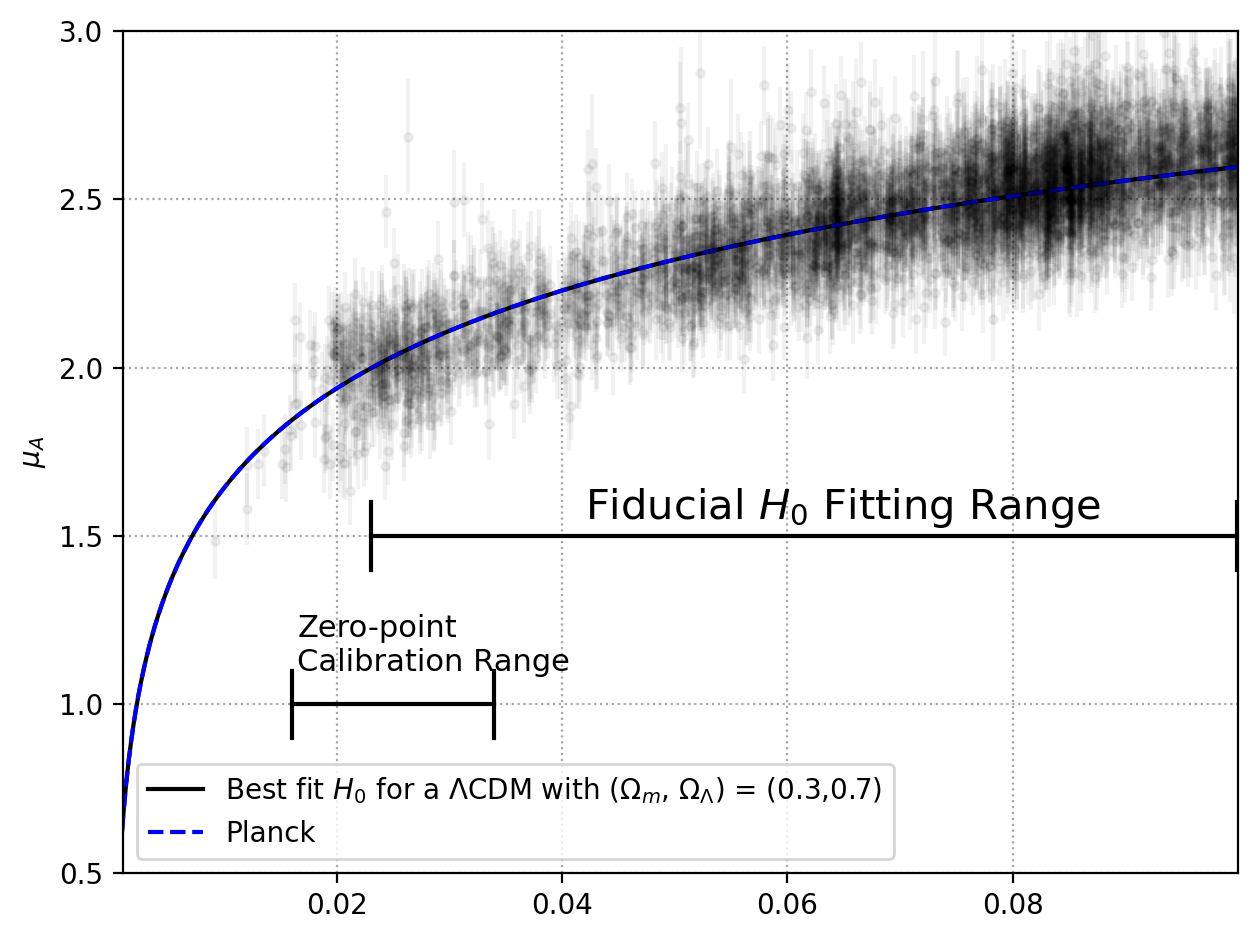

In [214]:
plt.errorbar(fit_data.zcmb,fit_data.mu_a_cal,yerr=fit_data.mu_a_err,fmt=".k",alpha=0.05)
plt.grid(visible=True, which='both', color='0.65',linestyle=':')
x_fit = np.linspace(0.0001,0.11,1000)


fitted_k_modulus_only_H0 = k_modulus(x_fit, H0_fitted, fixed_q0, fixed_j0)

plt.plot(x_fit, fitted_k_modulus_only_H0, label='Best fit $H_0$ for a $\Lambda$CDM with ($\Omega_m$, $\Omega_{\Lambda}$) = (0.3,0.7)', color='k')



fitted_k_modulus_Planck = k_modulus(x_fit, 67.4, -0.5275, fixed_j0)
plt.plot(x_fit, fitted_k_modulus_Planck, label='Planck', color='b',ls="--")



plt.plot([0.023,0.0999],[1.5,1.5],'-k',lw=1.5)
plt.plot([0.023,0.023],[1.4,1.6],'-k',lw=1.5)
plt.plot([0.0999,0.0999],[1.4,1.6],'-k',lw=1.5)
plt.text(0.042,1.55,"Fiducial $H_0$ Fitting Range",color='k',size=15) #, fontname = 'Times New Roman'

plt.plot([0.016,0.034],[1.0,1.0],'-k',lw=1.5)
plt.plot([0.016,0.016],[0.9,1.1],'-k',lw=1.5)
plt.plot([0.034,0.034],[0.9,1.1],'-k',lw=1.5)
plt.text(0.0165,1.1,"Zero-point\nCalibration Range",color='k',size=11) #, fontname = 'Times New Roman'

plt.ylabel(r'$\mu_{A}$')
plt.legend()
plt.xlim(0.001,np.max(fit_data.zcmb))
plt.ylim(0.5,3.0)

plt.tight_layout()
plt.savefig('Hubble_diagram_test_tilt.pdf')
plt.savefig('Hubble_diagram_test_tilt.png',dpi=360)
plt.show()

In [215]:
eta_back = fuji_pv_highz["r"] - fuji_pv_highz["mu_a_cal"] - np.log10(fuji_pv_highz["circ_radius"]) - np.log10(np.pi/648.) - np.log10(0.7142552976791121)

In [216]:
diff_eta = eta_back - fuji_pv_highz["logdist"]
diff_eta

0       0.000345
1      -0.003537
2      -0.006407
4       0.001497
6       0.001915
          ...   
4186   -0.090044
4187   -0.022919
4188   -0.029192
4189   -0.056327
4190   -0.034072
Length: 4063, dtype: float64

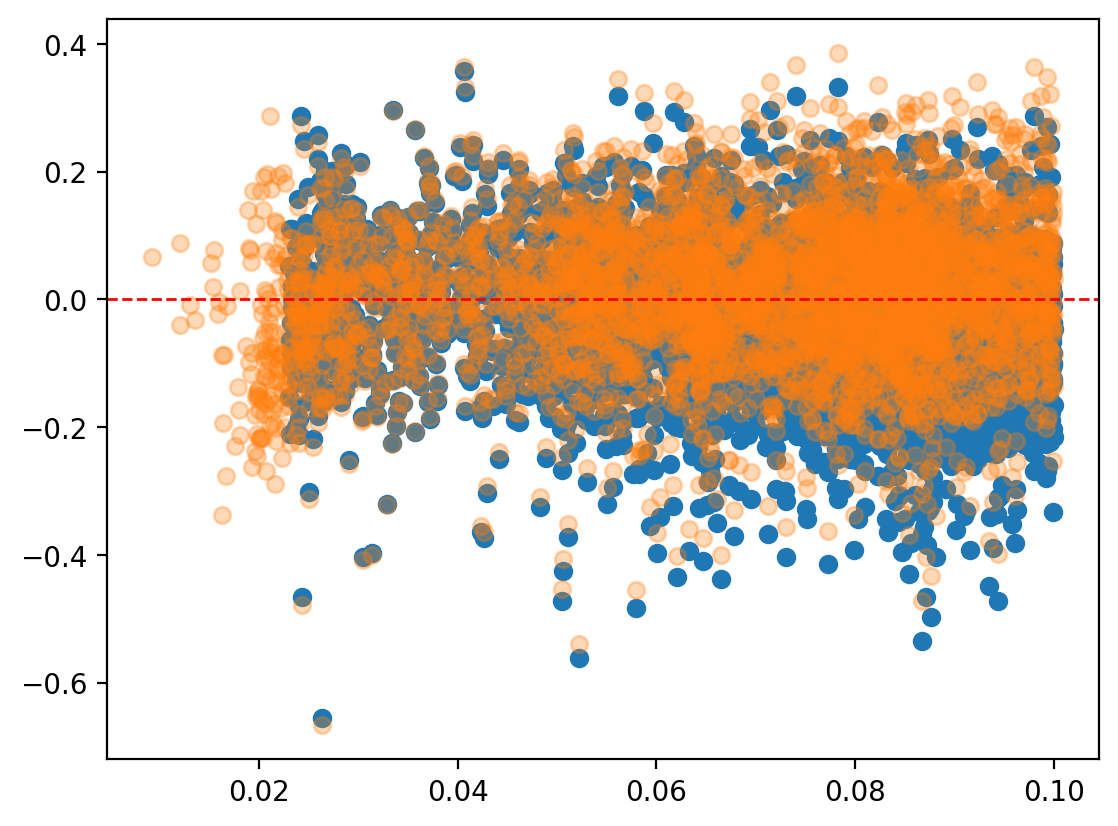

In [217]:
plt.scatter(fuji_pv_highz["zcmb"],eta_back)
plt.scatter(fit_data["zcmb"],fit_data["logdist_corr"],alpha=0.3)
#plt.scatter(fit_data["zcmb"],fit_data["logdist_corr"]-1.2*fit_data["zcmb"],alpha=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
plt.show()

/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/1431372360.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = fit_data.groupby('zcmb_binned')['logdist_corr'].mean().reset_index()


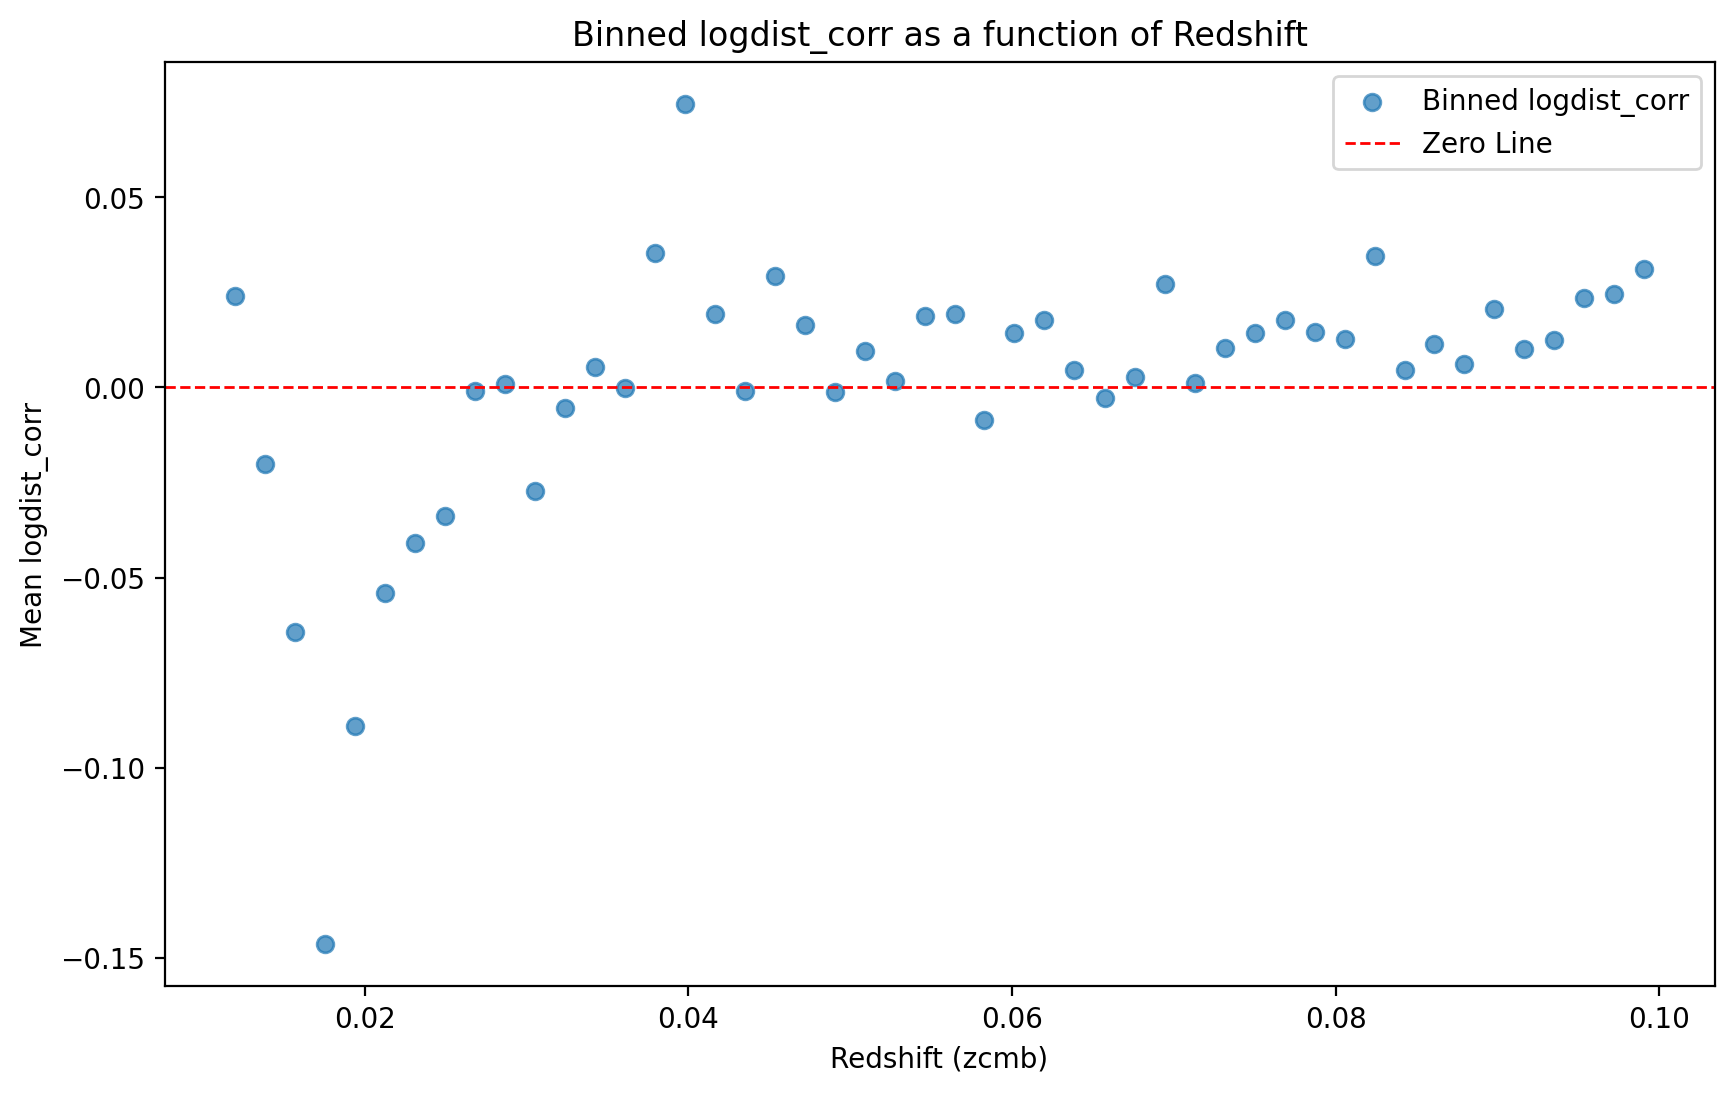

In [218]:
# Step 1: Define the bins for zcmb
bins = np.linspace(fit_data['zcmb'].min(), fit_data['zcmb'].max(), num=50)  # Adjust the number of bins as needed

# Step 2: Use pd.cut to bin the zcmb values
fit_data['zcmb_binned'] = pd.cut(fit_data['zcmb'], bins)

# Step 3: Group by the bins and calculate the mean logdist_corr for each bin
binned_data = fit_data.groupby('zcmb_binned')['logdist_corr'].mean().reset_index()

# Calculate the bin centers for plotting
bin_centers = [interval.mid for interval in binned_data['zcmb_binned']]

# Step 4: Plot the binned data
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, binned_data['logdist_corr'], alpha=0.7, label='Binned logdist_corr')

# Add a horizontal zero line
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')

plt.xlabel('Redshift (zcmb)')
plt.ylabel('Mean logdist_corr')
plt.title('Binned logdist_corr as a function of Redshift')
plt.legend()
plt.show()

/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/1165778166.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuji_pv_highz['zcmb_binned'] = pd.cut(fuji_pv_highz['zcmb'], bins)
/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/1165778166.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuji_pv_highz['eta_back'] = eta_back
/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/1165778166.py:23: FutureWarning: The default of observed=False is deprecated and will be

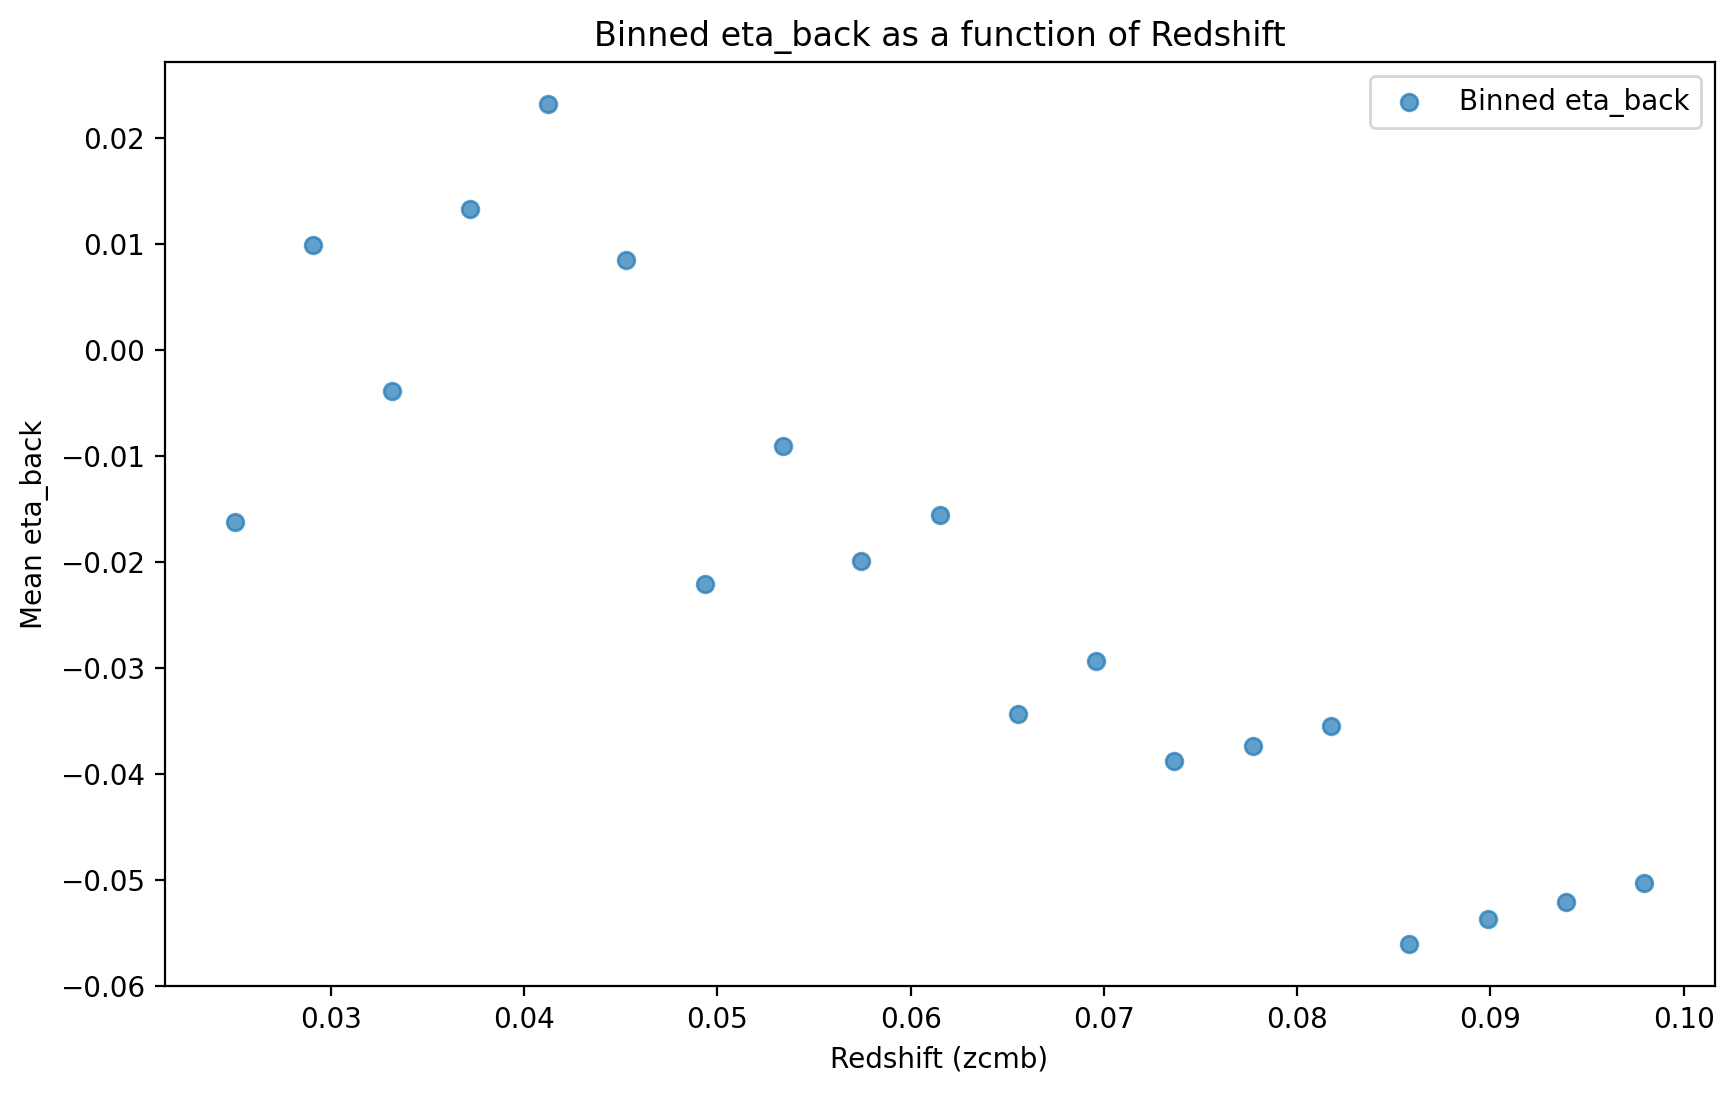

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming fit_data is already loaded as a DataFrame and eta_back is calculated
# Example calculation of eta_back (replace this with your actual calculation)
# eta_back = some_calculation_based_on_fit_data

# Step 1: Ensure eta_back is available
# For demonstration, let's assume eta_back is a numpy array of the same length as fit_data
# eta_back = np.random.random(len(fit_data))  # Replace with actual eta_back calculation

# Step 2: Define the bins for zcmb
bins = np.linspace(fuji_pv_highz['zcmb'].min(), fuji_pv_highz['zcmb'].max(), num=20)  # Adjust the number of bins as needed

# Step 3: Use pd.cut to bin the zcmb values
fuji_pv_highz['zcmb_binned'] = pd.cut(fuji_pv_highz['zcmb'], bins)

# Step 4: Add eta_back to the DataFrame
fuji_pv_highz['eta_back'] = eta_back

# Step 5: Group by the bins and calculate the mean eta_back for each bin
binned_data = fuji_pv_highz.groupby('zcmb_binned')['eta_back'].mean().reset_index()

# Calculate the bin centers for plotting
bin_centers = [interval.mid for interval in binned_data['zcmb_binned']]

# Step 6: Plot the binned data
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, binned_data['eta_back'], alpha=0.7, label='Binned eta_back')
plt.xlabel('Redshift (zcmb)')
plt.ylabel('Mean eta_back')
plt.title('Binned eta_back as a function of Redshift')
plt.legend()
plt.show()

/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/3901915417.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = fit_data.groupby('zcmb_binned')['logdist_corr'].mean().reset_index()
/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/3901915417.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data_adjusted = fit_data.groupby('zcmb_binned')['logdist_corr_adjusted'].mean().reset_index()


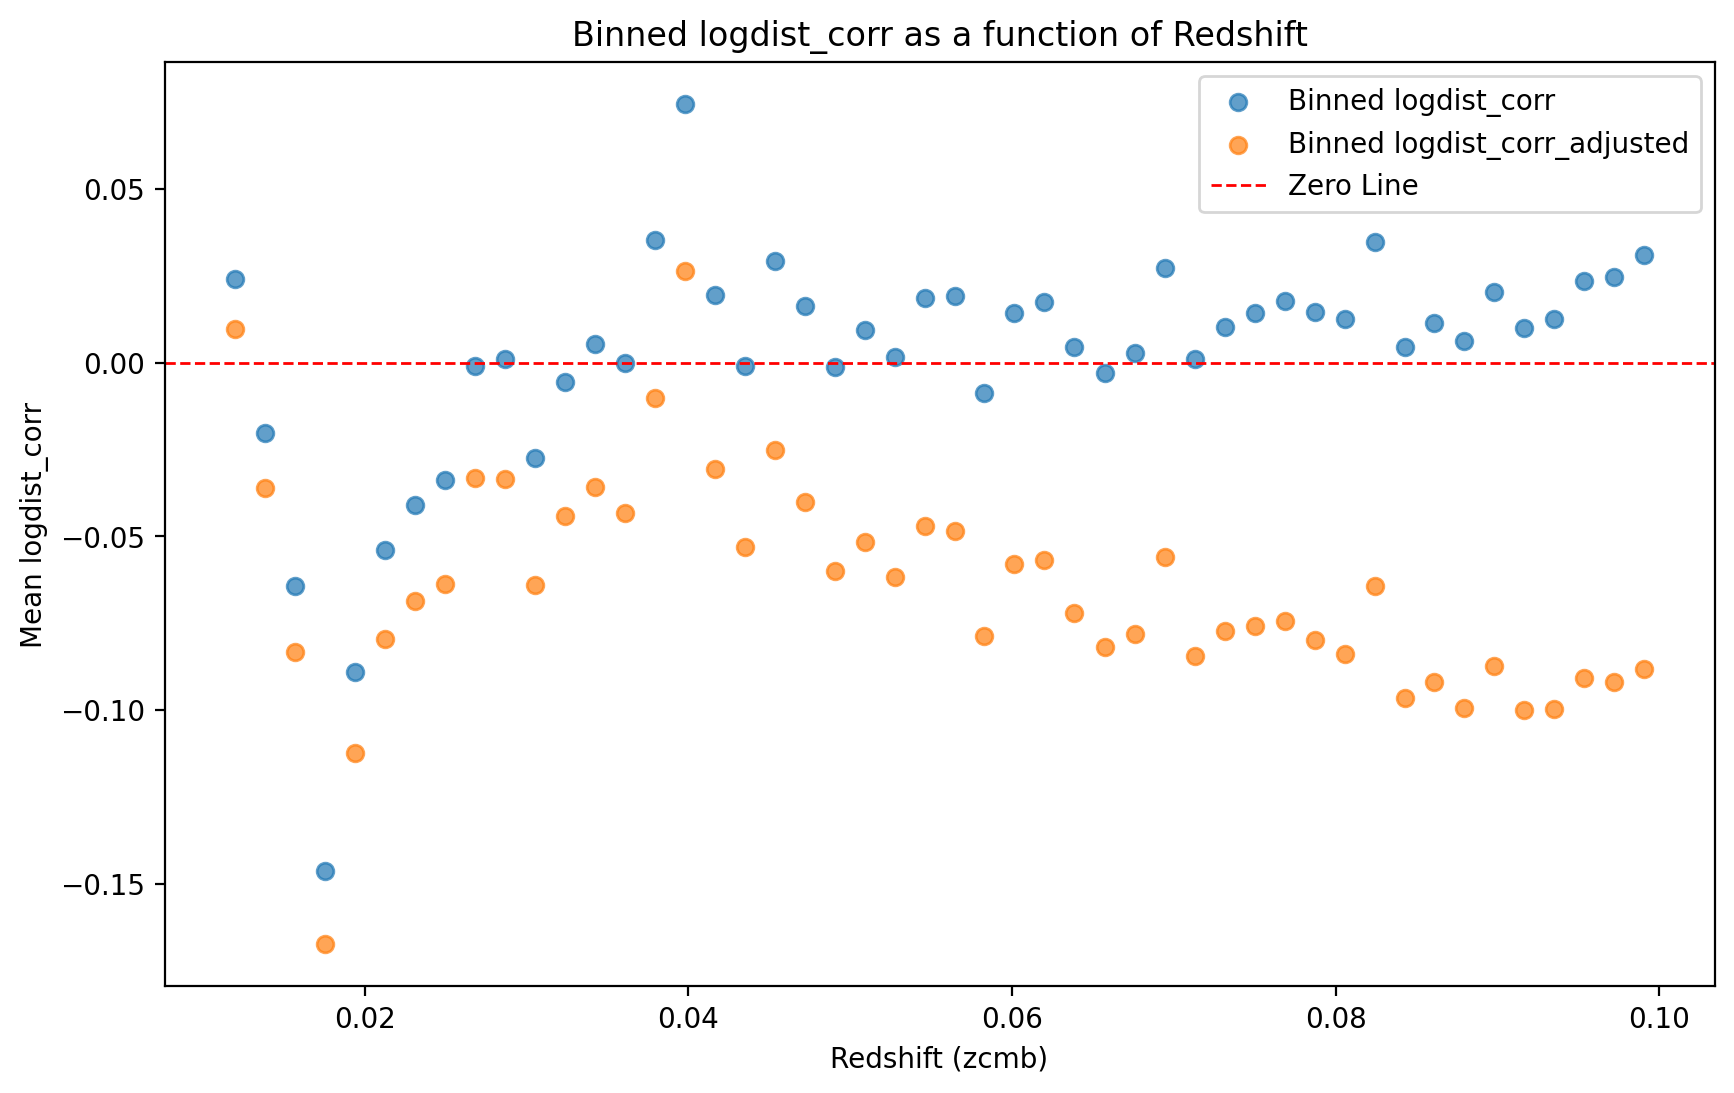

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming fit_data is already loaded as a DataFrame

# Step 1: Define the bins for zcmb
bins = np.linspace(fit_data['zcmb'].min(), fit_data['zcmb'].max(), num=50)  # Adjust the number of bins as needed

# Step 2: Use pd.cut to bin the zcmb values
fit_data['zcmb_binned'] = pd.cut(fit_data['zcmb'], bins)

# Step 3: Group by the bins and calculate the mean logdist_corr for each bin
binned_data = fit_data.groupby('zcmb_binned')['logdist_corr'].mean().reset_index()

# Calculate the bin centers for plotting
bin_centers = [interval.mid for interval in binned_data['zcmb_binned']]

# Step 4: Create a new column for adjusted logdist_corr
fit_data['logdist_corr_adjusted'] = fit_data['logdist_corr'] - 1.2 * fit_data['zcmb']

# Step 5: Group by the bins and calculate the mean adjusted logdist_corr for each bin
binned_data_adjusted = fit_data.groupby('zcmb_binned')['logdist_corr_adjusted'].mean().reset_index()

# Calculate the bin centers for plotting (same as before)
bin_centers_adjusted = [interval.mid for interval in binned_data_adjusted['zcmb_binned']]

# Step 6: Plot the binned data
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, binned_data['logdist_corr'], alpha=0.7, label='Binned logdist_corr')
plt.scatter(bin_centers_adjusted, binned_data_adjusted['logdist_corr_adjusted'], alpha=0.7, label='Binned logdist_corr_adjusted')

# Add a horizontal zero line
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')

plt.xlabel('Redshift (zcmb)')
plt.ylabel('Mean logdist_corr')
plt.title('Binned logdist_corr as a function of Redshift')
plt.legend()
plt.show()

/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/716321038.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_data_cutoff['zcmb_binned'] = pd.cut(fit_data_cutoff['zcmb'], bins)
/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/716321038.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = fit_data_cutoff.groupby('zcmb_binned')['logdist_corr'].mean().reset_index()
/var/folders/8p/jzppkr8j2_71k5rqwdr5rk800000gp/T/ipykernel_2978/716321038.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

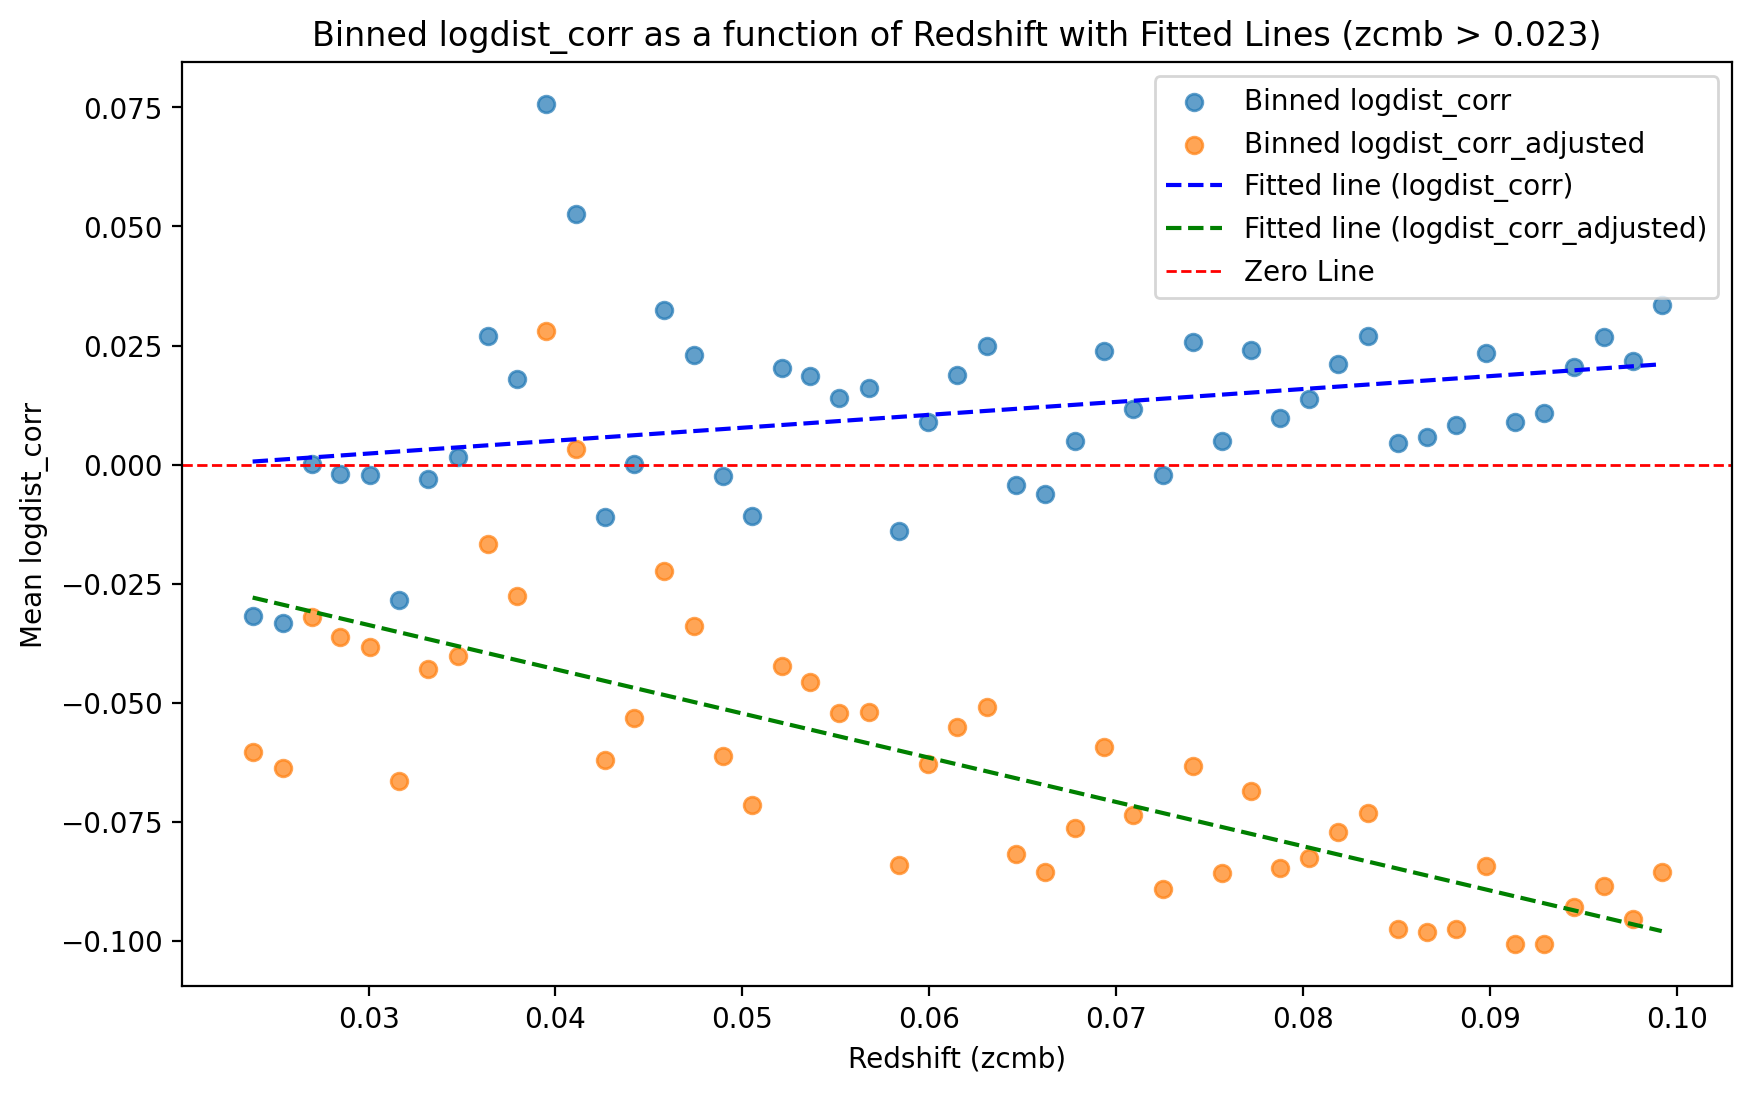

Fitted line equation for logdist_corr: y = 0.2710x + -0.0058
Fitted line equation for logdist_corr_adjusted: y = -0.9290x + -0.0058

Number of valid data points for logdist_corr: 49
Number of valid data points for logdist_corr_adjusted: 49

Range of bin_centers: 0.0238 to 0.0992
Range of logdist_corr: -0.0332 to 0.0756
Range of logdist_corr_adjusted: -0.1008 to 0.0281


In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Assuming fit_data is already loaded as a DataFrame

# Apply the redshift cutoff
fit_data_cutoff = fit_data[fit_data['zcmb'] > 0.023]

# Step 1: Define the bins for zcmb
bins = np.linspace(fit_data_cutoff['zcmb'].min(), fit_data_cutoff['zcmb'].max(), num=50)  # Adjust the number of bins as needed

# Step 2: Use pd.cut to bin the zcmb values
fit_data_cutoff['zcmb_binned'] = pd.cut(fit_data_cutoff['zcmb'], bins)

# Step 3: Group by the bins and calculate the mean logdist_corr for each bin
binned_data = fit_data_cutoff.groupby('zcmb_binned')['logdist_corr'].mean().reset_index()

# Calculate the bin centers for plotting
bin_centers = np.array([interval.mid for interval in binned_data['zcmb_binned']])

# Step 4: Create a new column for adjusted logdist_corr
fit_data_cutoff['logdist_corr_adjusted'] = fit_data_cutoff['logdist_corr'] - 1.2 * fit_data_cutoff['zcmb']

# Step 5: Group by the bins and calculate the mean adjusted logdist_corr for each bin
binned_data_adjusted = fit_data_cutoff.groupby('zcmb_binned')['logdist_corr_adjusted'].mean().reset_index()

# Calculate the bin centers for plotting (same as before)
bin_centers_adjusted = np.array([interval.mid for interval in binned_data_adjusted['zcmb_binned']])

# Remove NaN values
valid_data = ~np.isnan(binned_data['logdist_corr'])
valid_data_adjusted = ~np.isnan(binned_data_adjusted['logdist_corr_adjusted'])

# Fit straight lines to both datasets, excluding NaN values
slope, intercept, r_value, p_value, std_err = stats.linregress(bin_centers[valid_data], binned_data['logdist_corr'][valid_data])
slope_adjusted, intercept_adjusted, r_value_adjusted, p_value_adjusted, std_err_adjusted = stats.linregress(bin_centers_adjusted[valid_data_adjusted], binned_data_adjusted['logdist_corr_adjusted'][valid_data_adjusted])

# Create line data
line = slope * bin_centers + intercept
line_adjusted = slope_adjusted * bin_centers_adjusted + intercept_adjusted

# Step 6: Plot the binned data and fitted lines
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, binned_data['logdist_corr'], alpha=0.7, label='Binned logdist_corr')
plt.scatter(bin_centers_adjusted, binned_data_adjusted['logdist_corr_adjusted'], alpha=0.7, label='Binned logdist_corr_adjusted')

# Plot fitted lines
plt.plot(bin_centers, line, color='blue', linestyle='--', label='Fitted line (logdist_corr)')
plt.plot(bin_centers_adjusted, line_adjusted, color='green', linestyle='--', label='Fitted line (logdist_corr_adjusted)')

# Add a horizontal zero line
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')

plt.xlabel('Redshift (zcmb)')
plt.ylabel('Mean logdist_corr')
plt.title('Binned logdist_corr as a function of Redshift with Fitted Lines (zcmb > 0.023)')
plt.legend()
plt.show()

# Print the fitted line equations
print(f"Fitted line equation for logdist_corr: y = {slope:.4f}x + {intercept:.4f}")
print(f"Fitted line equation for logdist_corr_adjusted: y = {slope_adjusted:.4f}x + {intercept_adjusted:.4f}")

# Print additional information about the data
print(f"\nNumber of valid data points for logdist_corr: {sum(valid_data)}")
print(f"Number of valid data points for logdist_corr_adjusted: {sum(valid_data_adjusted)}")
print(f"\nRange of bin_centers: {bin_centers.min():.4f} to {bin_centers.max():.4f}")
print(f"Range of logdist_corr: {binned_data['logdist_corr'].min():.4f} to {binned_data['logdist_corr'].max():.4f}")
print(f"Range of logdist_corr_adjusted: {binned_data_adjusted['logdist_corr_adjusted'].min():.4f} to {binned_data_adjusted['logdist_corr_adjusted'].max():.4f}")

In [227]:
print (np.mean(fit_data["zcmb"]))
print (np.median(fit_data["zcmb"]))


0.06853937358940874
0.0737979412634457


In [228]:
mu_adjusted = fit_data["r"] - fit_data["logdist_corr_adjusted"] - np.log10(fit_data["circ_radius"]) - np.log10(np.pi/648.) - np.log10(0.7142552976791121)

In [238]:
fixed_q0 = -0.535
fixed_j0 = 1.

x0 = fit_data.zcmb 
y0 = mu_adjusted - 0.63*fit_data.zcmb
err0 = fit_data.mu_a_err


def modified_k_modulus(z, H0):
    return k_modulus(z, H0, fixed_q0, fixed_j0)

initial_guess = [50.]

params_mod, cov_mod = curve_fit(modified_k_modulus, x0, y0, p0=initial_guess, sigma=err0)

H0_fit_mod = params_mod
H0_uncertainty_mod = cov_mod

print(np.round(H0_fit_mod[0],2),"+/-",np.round(H0_uncertainty_mod[0][0],2))

n = len(x0)
residuals = y0 - modified_k_modulus(x0, H0_fit_mod)
chi2_value = np.sum((residuals / err0) ** 2)
dof = n - 1 
alpha = 0.05

uncertainty = np.sqrt(np.sum(residuals**2) / dof)

reduced_chi2 = chi2_value / dof

print(f'Fitted Hubble Constant (H0): {np.round(H0_fit_mod,2)} km/s/Mpc')
print(f'Uncertainty (standard error): {uncertainty:.2f}')
print(f'Reduced Chi-squared: {reduced_chi2:.2f}')

67.47 +/- 0.07
Fitted Hubble Constant (H0): [67.47] km/s/Mpc
Uncertainty (standard error): 0.12
Reduced Chi-squared: 1.04
